## Survival analysis and lifespan modeling

In [23]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width  = 12, repr.plot.height = 8)
set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [33]:
# run if working on colab
install.packages(c('survival', 'survminer', 'gtsummary'))

library(survival)
library(survminer)
library(gtsummary)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘png’, ‘jpeg’, ‘V8’, ‘reactR’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘gridtext’, ‘bigD’, ‘bitops’, ‘juicyjuice’, ‘markdown’, ‘reactable’, ‘ggpubr’, ‘gridExtra’, ‘maxstat’, ‘survMisc’, ‘ggtext’, ‘cards’, ‘gt’


Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [ ]:
install.packages(c('plyr', 'doParallel', 'foreach'))
library(plyr); library(doParallel); library(foreach)

## Backblaze data

 >Each day at each Backblaze data center, we take a snapshot of each operational drive. This snapshot includes basic drive information along with the S.M.A.R.T. statistics reported by that drive. The daily snapshot of one drive is one record or row of data. All of the drive snapshots for a given day are collected into a file consisting of a row for each active drive. The format of this file is a ".csv" (Comma Separated Values) file. Each day this file is named in the format YYYY-MM-DD.csv, for example, 2024-03-25.csv.

‍
- SMART 5: Reallocated Sectors Count
- SMART 9: Number of powered-on hours
- SMART 187: Reported Uncorrectable Errors
- SMART 188: Command Timeout
- SMART 197: Current Pending Sector Count
- SMART 198: Offline Uncorrectable


### Data Retrieval

Can skip this if loading the bb_raw.RData directly

In [ ]:
col_spec <- cols_only(
  date = col_date(),
  serial_number = col_character (),
  model = col_character(),
  capacity_bytes = col_double(),
  failure = col_logical(),
  smart_5_raw = col_double(),
  smart_9_raw = col_double(),
  smart_187_raw = col_double(),
  smart_188_raw = col_double(),
  smart_197_raw = col_double(),
  smart_198_raw = col_double(),
)

In [ ]:
for (year in 2016:2023){
  dfs <- list()
  for (q in 1:4){
    fn = paste0('data_Q', q, '_', year, '.zip')
    u <- paste0('https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/', fn)
    if (! file.exists(fn)){
      res <- download.file(u, fn)
    } else{
      res <- 0
    }
    if (res == 0){
      files <- unzip(fn, list = T, junkpaths = T)
      csvs <- files %>% mutate(fn = basename(Name)) %>% filter(
        startsWith(fn, as.character(year)),
        endsWith(fn, '.csv')
      ) %>% pluck('fn')

      # filtered_df <- files %>%
      #   filter(
      #     !str_detect(Name, "__MACOSX") &
      #     str_detect(Name, "/\\d{4}-\\d{2}-\\d{2}\\.csv$")
      #   )
      # csvs <- filtered_df$Name

      df_qtr = list()
      for (csv in csvs) {

        # Read the CSV file from the zip archive
        df <- readr::read_csv(unz(paste0("/content/", fn), csv), col_types = col_spec)

        # Append the data frame to the list
        df_qtr <- append(df_qtr, list(df))
      }
      dfs <- append(dfs, df_qtr)
    }
  }
  dfs <- list_rbind(dfs)
  save(dfs, file=paste0('bb_', year, '.RData'))
  message(year, '\r', appendLF = FALSE)
  flush.console()
}

In [ ]:
all_dfs <- list()

# Loop through the years, loading each file
for (year in 2016:2023) {
  # Construct the filename
  filename <- paste0('bb_', year, '.RData')

  # Load the .RData file
  load(filename)
  dfs %>% group_by(serial_number, model) %>%
    summarize(max(date, na.rm = T), min(date, na.rm = T), max(log2(capacity_bytes)),
      max(failure, na.rm=T), min(failure, na.rm=T), across(starts_with('smart'), \(v) max(v, na.rm=T))) -> dfs_reduced

  # Assuming each RData loads a variable named `dfs_combined`, if they all have the same name
  # If the variable name is different, replace `dfs_combined` with the appropriate variable name
  all_dfs[[as.character(year)]] <- dfs_reduced
}

# Combine all data frames into one
combined_df <- do.call(rbind, all_dfs)

In [ ]:
save(combined_df, file='2016-2023.RData')

### Load Data

In [17]:
load('bb_raw.RData')

In [ ]:
bb_raw <- bb_raw %>%
  rename(
    retired_date = `max(date, na.rm = T)`,
    launched_date = `min(date, na.rm = T)`,
    capacity_log = `max(log2(capacity_bytes))`,
    failure = `max(failure, na.rm = T)`,
  )

In [21]:
bb_raw %>% head()

serial_number,model,retired_date,launched_date,capacity_log,failure,"min(failure, na.rm = T)",smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw
<chr>,<chr>,<date>,<date>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13H2B97AS,TOSHIBA DT01ACA300,2016-12-31,2016-01-01,41.44838,0,0,0,25034,-Inf,-Inf,0,0
13H32WEAS,TOSHIBA DT01ACA300,2016-12-31,2016-01-01,41.44838,0,0,0,32285,-Inf,-Inf,0,0
13H6A21GS,TOSHIBA DT01ACA300,2016-12-31,2016-01-01,41.44838,0,0,0,31651,-Inf,-Inf,0,0
13H7X2HAS,TOSHIBA DT01ACA300,2016-12-31,2016-01-01,41.44838,0,0,0,18895,-Inf,-Inf,0,0
13H85BMGS,TOSHIBA DT01ACA300,2016-12-31,2016-01-01,41.44838,0,0,0,28896,-Inf,-Inf,0,0
13H87YWAS,TOSHIBA DT01ACA300,2016-12-31,2016-01-01,41.44838,0,0,0,31856,-Inf,-Inf,0,0


In [24]:
# estimated running time: 3m

bb_raw <- bb_raw %>%
  mutate(manufacturer = case_when(
    str_detect(model, "HGST") ~ "Hitachi",
    str_detect(model, "ST") ~ "Seagate",
    str_detect(model, "TOSHIBA") ~ "Toshiba",
    str_detect(model, "WDC") ~ "Western Digital",
    str_detect(model, "WD") ~ "Western Digital",
    str_detect(model, "Hitachi") ~ "Hitachi",
    TRUE ~ "Other"
  ))

In [25]:
bb_raw %>%
  group_by(serial_number, model) %>%
  summarize(retired_date = max(retired_date, na.rm = TRUE),
            across(everything(), ~if (is.numeric(.x)) max(.x, na.rm = TRUE) else first(.x))) %>%
  ungroup() -> bb_final

Warning message:
“There were 18547 warnings in `summarize()`.
The first warning was:
ℹ In argument: `across(everything(), ~if (is.numeric(.x)) max(.x, na.rm = TRUE)
  else first(.x))`.
ℹ In group 439: `serial_number = "1060A00AF9RG"` and `model = "TOSHIBA
  MG07ACA14TEY"`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 18546 remaining warnings.”
`summarise()` has grouped output by 'serial_number'. You can override using the
`.groups` argument.


In [26]:
bb_final <- bb_final %>%
  mutate(duration = as.numeric(difftime(retired_date, launched_date, units = "days")))

In [27]:
unique(bb_final$manufacturer)

[1] "Other"           "Toshiba"         "Hitachi"         "Western Digital"
[5] "Seagate"

In [28]:
# keep only four manufacturer: seagate, Toshiba, Western Digital and Hitachi

bb_final <- bb_final %>%
  filter(manufacturer %in% c("Seagate", "Toshiba", "Western Digital", "Hitachi"))

In [29]:
bb_final %>% head()

serial_number,model,retired_date,launched_date,capacity_log,failure,"min(failure, na.rm = T)",smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,manufacturer,duration
<chr>,<chr>,<date>,<date>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1030A001F97G,TOSHIBA MG07ACA14TA,2023-12-31,2020-11-10,43.67055,0,0,0,27811,-Inf,-Inf,0,0,Toshiba,1146
1030A007F97G,TOSHIBA MG07ACA14TA,2023-12-31,2021-04-08,43.67055,0,0,0,24222,-Inf,-Inf,0,0,Toshiba,997
1030A009F9RG,TOSHIBA MG07ACA14TEY,2023-12-31,2022-08-26,43.67055,0,0,0,11815,-Inf,-Inf,-Inf,0,Toshiba,492
1030A00CF9RG,TOSHIBA MG07ACA14TEY,2023-12-31,2021-01-08,43.67055,0,0,0,26854,-Inf,-Inf,-Inf,0,Toshiba,1087
1030A00DF97G,TOSHIBA MG07ACA14TA,2023-12-31,2021-09-22,43.67055,0,0,0,20011,-Inf,-Inf,0,0,Toshiba,830
1030A00DF9RG,TOSHIBA MG07ACA14TEY,2023-12-31,2021-01-08,43.67055,0,0,0,26865,-Inf,-Inf,-Inf,0,Toshiba,1087


### Analysis

#### Kaplan-Meier

##### Proportional hazards regression
- The K-M estimator is _non-parametric_; it estimates a whole function without assuming any model.
- If we want to be able to interpret the effect of different covariates on survival, we need a model which relates
the covariates to the outcome (lifespan).
    - We are going to model the hazard rate function directly.
    - The approach we will use is similar to how we used generalized linear modeling to allow differences in the mean parameter for various distributions.

In [ ]:
# load('/content/bb_final.RData')

In [31]:
bb_final %>% head

serial_number,model,retired_date,launched_date,capacity_log,failure,"min(failure, na.rm = T)",smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,manufacturer,duration
<chr>,<chr>,<date>,<date>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1030A001F97G,TOSHIBA MG07ACA14TA,2023-12-31,2020-11-10,43.67055,0,0,0,27811,-Inf,-Inf,0,0,Toshiba,1146
1030A007F97G,TOSHIBA MG07ACA14TA,2023-12-31,2021-04-08,43.67055,0,0,0,24222,-Inf,-Inf,0,0,Toshiba,997
1030A009F9RG,TOSHIBA MG07ACA14TEY,2023-12-31,2022-08-26,43.67055,0,0,0,11815,-Inf,-Inf,-Inf,0,Toshiba,492
1030A00CF9RG,TOSHIBA MG07ACA14TEY,2023-12-31,2021-01-08,43.67055,0,0,0,26854,-Inf,-Inf,-Inf,0,Toshiba,1087
1030A00DF97G,TOSHIBA MG07ACA14TA,2023-12-31,2021-09-22,43.67055,0,0,0,20011,-Inf,-Inf,0,0,Toshiba,830
1030A00DF9RG,TOSHIBA MG07ACA14TEY,2023-12-31,2021-01-08,43.67055,0,0,0,26865,-Inf,-Inf,-Inf,0,Toshiba,1087


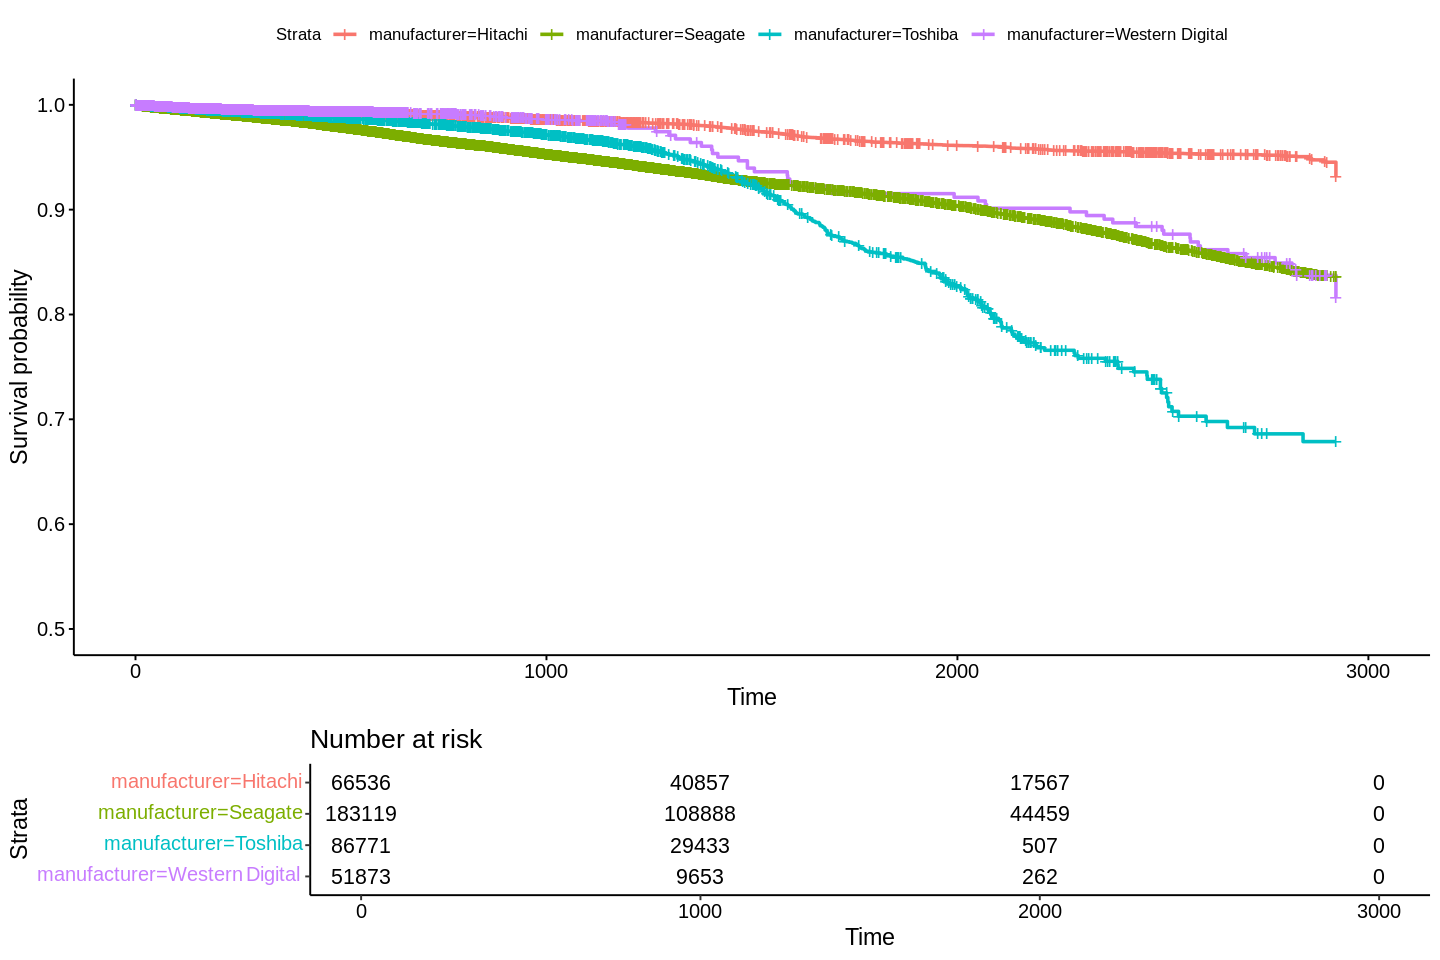

In [34]:
m_fit <- survfit(Surv(duration, failure) ~ manufacturer, data = bb_final)
ggsurvplot(m_fit, risk.table = TRUE, ylim = c(0.5, 1))

Call: survfit(formula = Surv(duration, failure) ~ manufacturer, data = bb_final)

                                  n events median 0.95LCL 0.95UCL
manufacturer=Hitachi          66536   1689     NA      NA      NA
manufacturer=Seagate         183119  13234     NA      NA      NA
manufacturer=Toshiba          86771   2211     NA      NA      NA
manufacturer=Western Digital  51873    397     NA      NA      NA

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Adding survival median lines is not allowed when fun is: cumhaz”


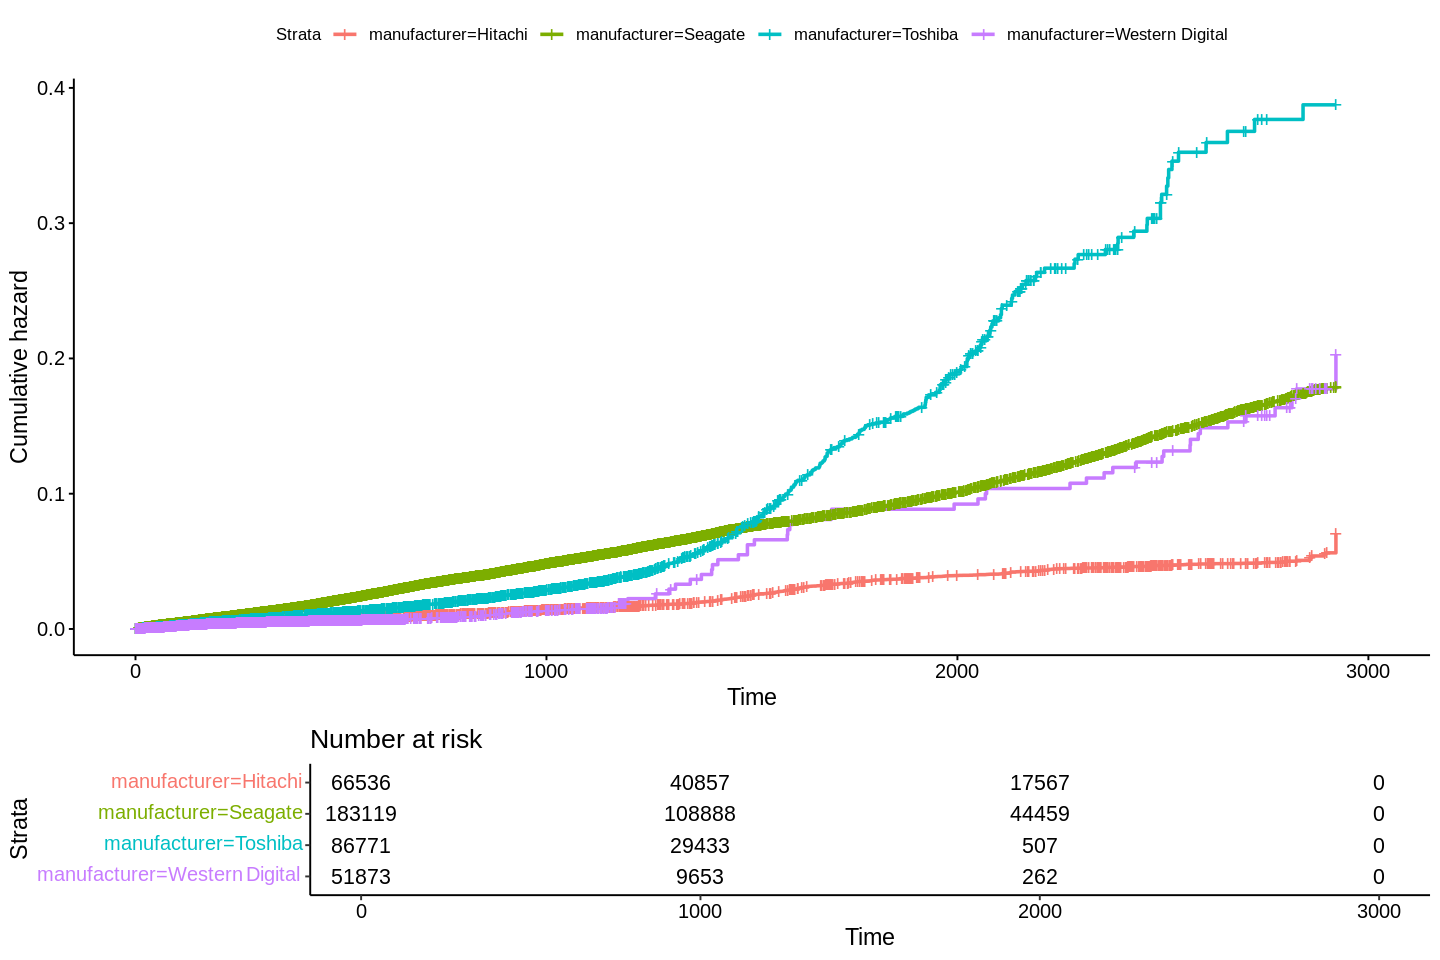

In [35]:
(km_fit <- survfit(Surv(duration, failure) ~ manufacturer, data = bb_final))
ggsurvplot(km_fit, risk.table = TRUE, surv.median.line = "hv", fun = "cumhaz")

In [36]:
(km_diff <- survdiff(Surv(duration, failure) ~ manufacturer, data = bb_final))

Call:
survdiff(formula = Surv(duration, failure) ~ manufacturer, data = bb_final)

                                  N Observed Expected (O-E)^2/E (O-E)^2/V
manufacturer=Hitachi          66536     1689     4046  1.37e+03  1.82e+03
manufacturer=Seagate         183119    13234    10372  7.90e+02  1.98e+03
manufacturer=Toshiba          86771     2211     2218  2.33e-02  2.81e-02
manufacturer=Western Digital  51873      397      894  2.77e+02  3.04e+02

 Chisq= 2458  on 3 degrees of freedom, p= <2e-16 

##### look at the impact of capacity size differnce

In [37]:
bb_final <- bb_final %>%
  mutate(capacity_tb = 2^(capacity_log) / 1024^4)

In [38]:
max(bb_final$capacity_tb) # the largest

[1] 20.00977

In [39]:
round_seq <- c(1.5, seq(3, 15, by=2))
round_seq
find_nearest <- function(x) {
    # Handle values less than 1 specially
    if (x < 1) return(0.5)

    # Find the closest value in our sequence
    dists <- abs(round_seq - x)
    round_seq[which.min(dists)]
}

[1]  1.5  3.0  5.0  7.0  9.0 11.0 13.0 15.0

In [40]:
# find the nearest tb size
bb_final$capacity_tb_rounded <- sapply(bb_final$capacity_tb, find_nearest)

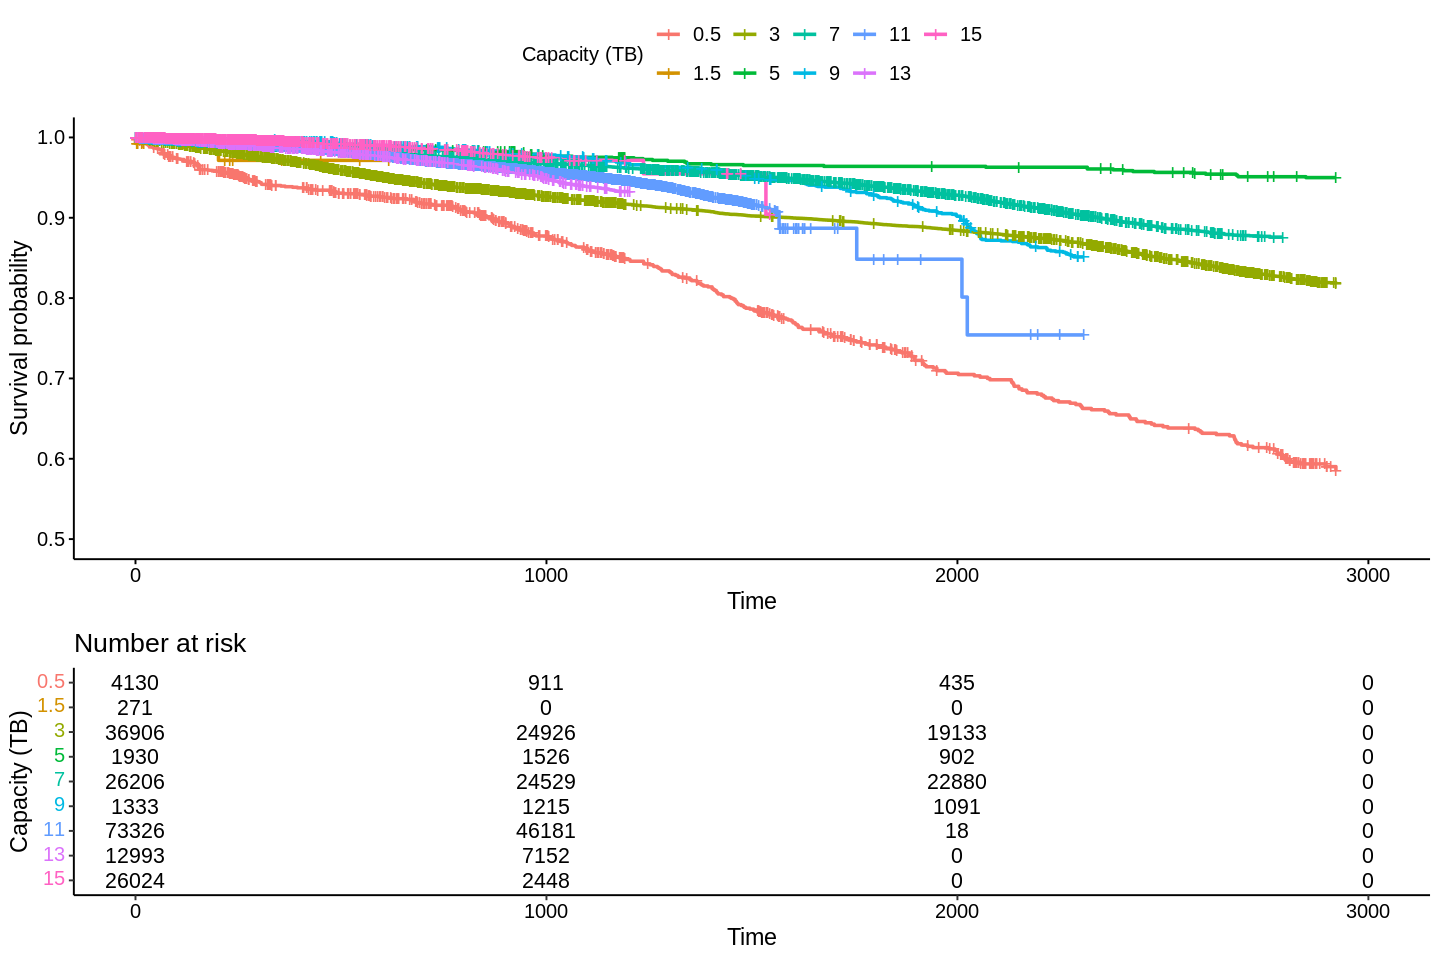

In [41]:
# Break down by size
# manufacturer: seagate
seagate <- bb_final %>% filter(manufacturer %in% c("Seagate"))
sea_m_fit <- survfit(Surv(duration, failure) ~ capacity_tb_rounded, data = seagate)

ggsurvplot(
  sea_m_fit,
  risk.table = TRUE,
  ylim = c(0.5, 1),
  legend.title = "Capacity (TB)",
  font.legend = 12,
  legend.labs =  levels(factor(seagate$capacity_tb_rounded)),
  font.tickslab = 12,
  # Adjust risk table
  risk.table.height = 0.35,
  legend.key.size = unit(1.2, "lines")
)

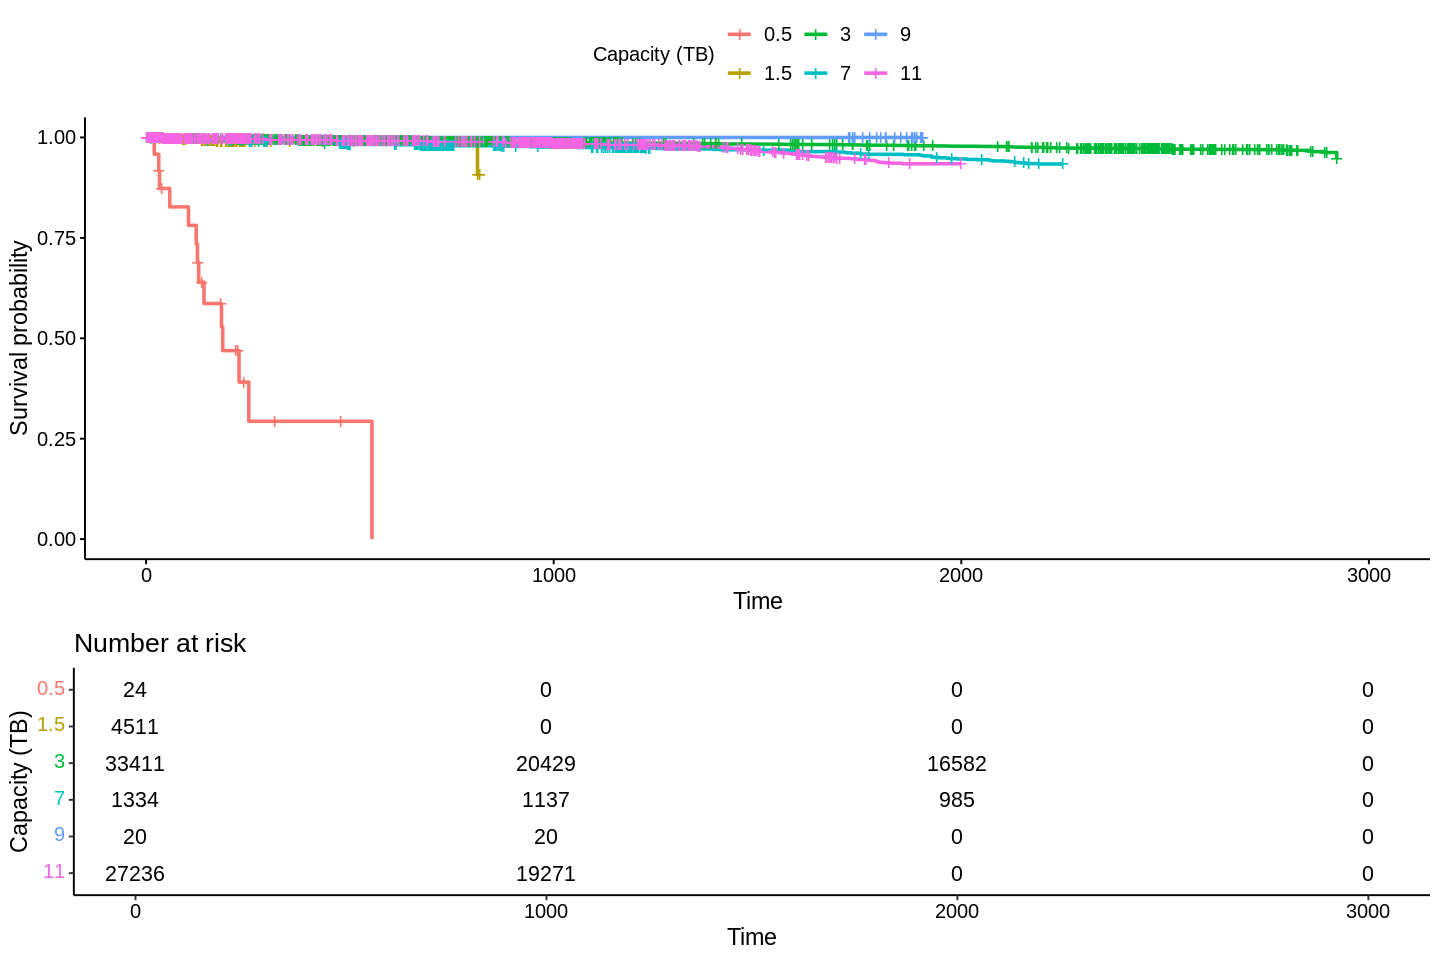

In [42]:
# manufacturer: hitachi
hitachi <- bb_final %>% filter(manufacturer %in% c("Hitachi"))
sea_m_fit <- survfit(Surv(duration, failure) ~ capacity_tb_rounded, data = hitachi)
# ggsurvplot(sea_m_fit, risk.table = TRUE, ylim = c(0.4, 1), surv.plot.height = 0.6,)
ggsurvplot(
  sea_m_fit,
  risk.table = TRUE,
  legend.title = "Capacity (TB)",
  font.legend = 12,
  legend.labs =  levels(factor(hitachi$capacity_tb_rounded)),
  font.tickslab = 12,
  # Adjust risk table
  risk.table.height = 0.35,
  legend.key.size = unit(1.2, "lines")
)

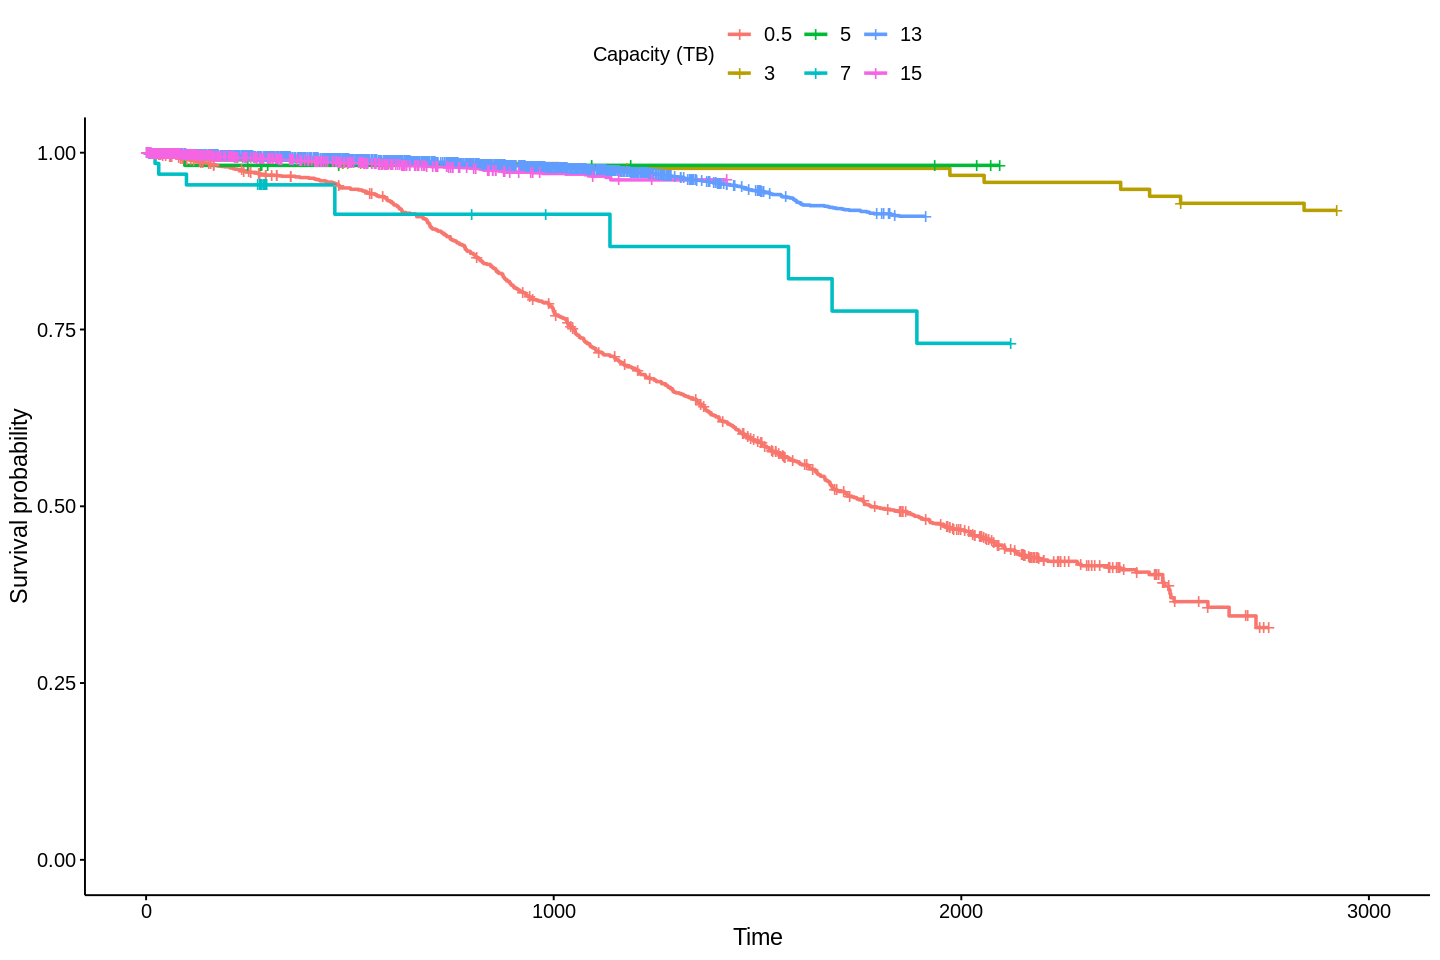

In [43]:
# manufacturer: toshiba
Toshiba <- bb_final %>% filter(manufacturer %in% c("Toshiba"))
sea_m_fit <- survfit(Surv(duration, failure) ~ capacity_tb_rounded, data = Toshiba)
ggsurvplot(
  sea_m_fit,
  legend.title = "Capacity (TB)",
  font.legend = 12,
  legend.labs =  levels(factor(Toshiba$capacity_tb_rounded)),
  font.tickslab = 12,
)

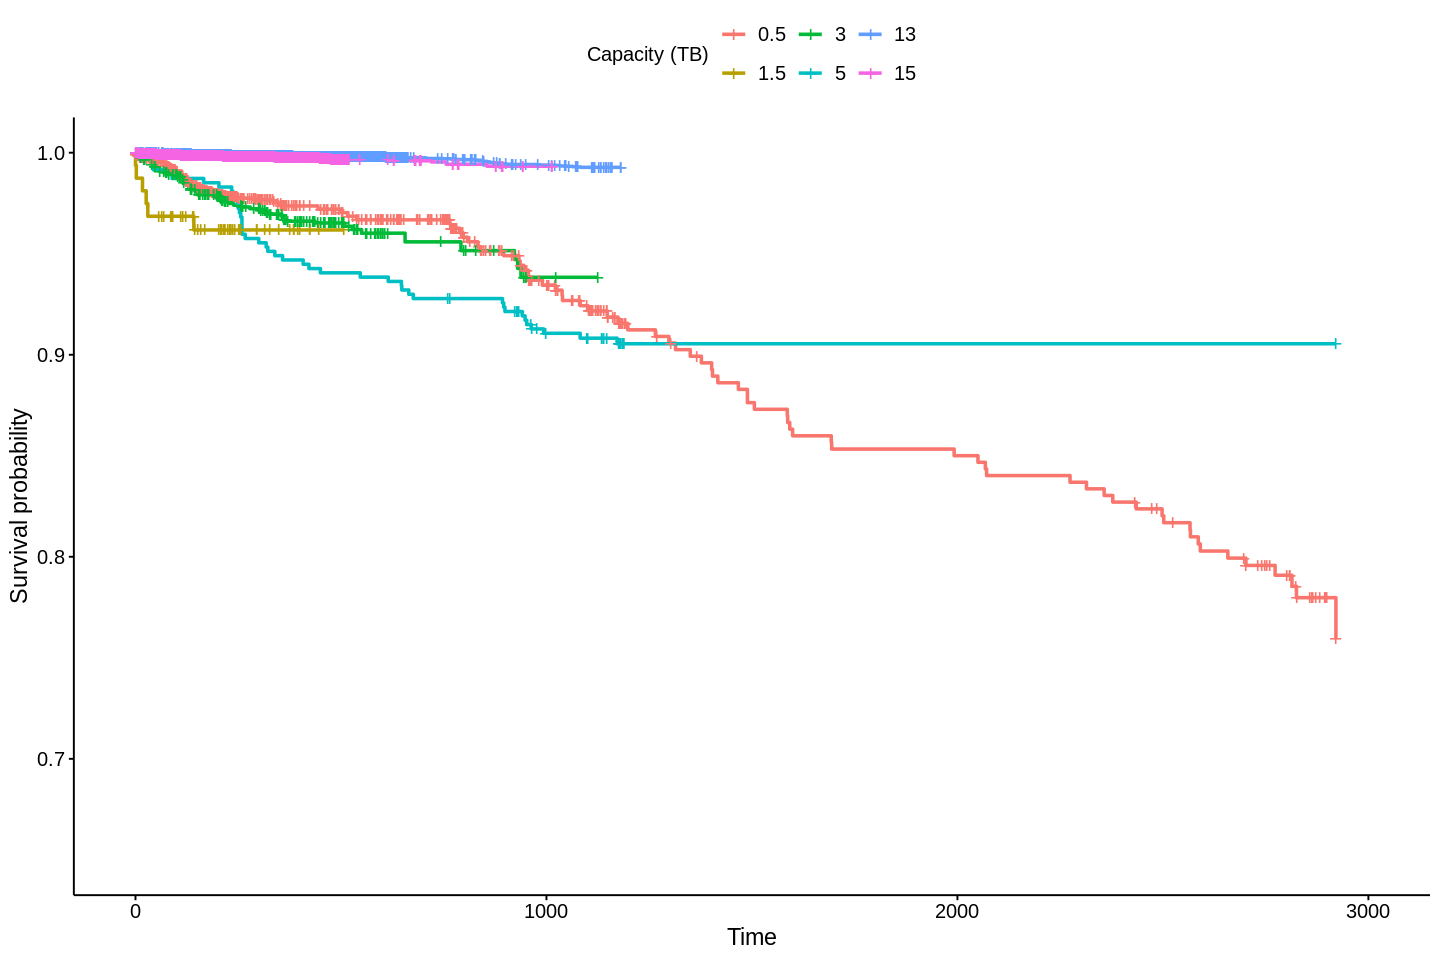

In [44]:
# manufacturer: Western Digital
WD <- bb_final %>% filter(manufacturer %in% c("Western Digital"))
sea_m_fit <- survfit(Surv(duration, failure) ~ capacity_tb_rounded, data = WD)
ggsurvplot(
  sea_m_fit,
  legend.title = "Capacity (TB)",
  font.legend = 12,
  ylim = c(0.65, 1),
  legend.labs =  levels(factor(WD$capacity_tb_rounded)),
  font.tickslab = 12,
)

#### The Cox model

- Let $\mathbf{Z}$ be a vector of individual-specific covariates.
- The proportional hazards model assumes that $$h(t\mid \mathbf{Z}) = h_0(t)c(\beta^\intercal \mathbf{Z}),$$ where $h_0$ is an unknown baseline hazard rate and $\mathbf{Z}\in\mathbb{R}^p$ is a vector of predictors.
- $c(\cdot)$ is analagous to the link function in GLM.
- The natural choice is $c=\exp$, leading to the famous Cox model.

**Interpretation**
- Let $S_0(t)=\exp(-\int_0^t h_0(s)\,ds)$ be the baseline survival function.
- Then $$S(t\mid \mathbf{Z}) = \exp\left(-\int_0^t h(s\mid \mathbf{Z})\,ds\right) = S_0(t)^{e^{\mathbf{Z}^\intercal \beta}}$$
- Additionally, $\log h(t\mid\mathbf{Z}) = \log h_0(t) + \mathbf{Z}^\intercal \beta$, so $\log h_0(t)$ is a sort of intercept term.
- The Cox model is essentially a multiple linear regression of the log hazard on covariates.
- This is known as a **semi-parametric** model: there is a parametric (finite dimensional) component $\beta$ as well as an infinite dimensional parameter $h_0(t)$.

**Proportional hazards property**


As already remarked, the Cox model has the proportional hazards property:
   - Let $\mathbf{Z},\mathbf{Z}^*$ be covariates for two different patients.
   - Then $$\frac{h(t\mid\mathbf{Z})}{h(t\mid\mathbf{Z}^*)} = \exp[\beta(\mathbf{Z}-\mathbf{Z}^*)],$$ i.e. it is constant over time.
   - In particular, if there is a single treatment effect $\beta$, the hazard ratio is $e^\beta$, similar to logistic regression.

**Estimating the proportional hazards model**
- Estimation is complicated by the fact that part of the model $h_0(t)$ is infinite dimensional.
- Cox's brilliant insight was that it is possible to estimate $\beta$ in spite of this!
- To overcome this we use a technique called *partial likelihoods*.
    - Say we observe deaths at times $t_1,\dots,t_D$.
    - The person who died at time $t_i$ is denoted "person $i$" and has covariates $\mathbf{Z}_i$.  (As usual, we assume no ties.)
    - Assuming no ties and independence between the life spans, we have $$\mathbb{P}(\text{data}) = \prod_{i=1}^D \underbrace{\mathbb{P}(\text{person $i$ died}\mid\text{somebody died at $t_i$})}_\text{(I)} \underbrace{\mathbb{P}(\text{somebody died at $t_i$})}_\text{(II)}$$
    - Term (I) is simply the softmax function which we studied in multinomial logit: $$\(\frac{\exp(\mathbf{Z}_i^\intercal \beta)}{\sum_{j \in R(t_i)} \exp(\mathbf{Z}_j^\intercal \beta)}\)$$ Here, the summation is over the set $R(t_i)$ of people who are at risk at time $t_i$.


**The partial likelihood**
- The partial likelihood is formed by considering the product of term (I) only. That is, we condition on the observed death times $t_1,\dots,t_D$ and do not use them for inference: $$L(\beta) = \prod_i \frac{\exp(\mathbf{Z}_i^\intercal \beta)}{\sum_{j\in R(t_i)} \exp(\mathbf{Z}_j^\intercal \beta)}.$$

**The MPLE**
- To fit the partial likelihood we maximize $\text{LL}(\beta)=\log L(\beta)$ with respect to $\beta$, obtaining the *maximum partial likelihood estimator* (MPLE).
- This can be accomplished by setting the score functions $$U_h = \frac{\partial \log L(\beta)}{\beta_h}=\sum_{i=1}^D Z_{ih} - \frac{\sum_{j\in R(t_i)} Z_{jh} \exp(\mathbf{Z}_j^\intercal \beta)}{\sum_{j\in R(t_i)} \exp(\mathbf{Z}_j^\intercal \beta)}$$ to zero.

**Interpreting the Cox model**

Similar to logistic regression:

- A negative coefficient estimator means the hazard decreases with increasing values of the variable.
- A one-unit increase in covariate causes the hazard ratio to increase/decrease by $\exp(\beta)$

**Assumptions of the Cox model**

- Hazards are actually proportional!
- Covariates and coefficients do not depend on time.
- Log hazard is a linear function of the covariates.

In [45]:
summary(bb_final %>% filter(capacity_log > -Inf)
%>% coxph(Surv(duration, failure) ~ manufacturer + capacity_log, data = .))

Call:
coxph(formula = Surv(duration, failure) ~ manufacturer + capacity_log, 
    data = .)

  n= 369956, number of events= 17304 

                                 coef exp(coef)  se(coef)       z Pr(>|z|)    
manufacturerSeagate          1.232634  3.430254  0.026037  47.341  < 2e-16 ***
manufacturerToshiba          1.121450  3.069302  0.033327  33.650  < 2e-16 ***
manufacturerWestern Digital  0.185883  1.204281  0.057485   3.234  0.00122 ** 
capacity_log                -0.349725  0.704882  0.006973 -50.157  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                            exp(coef) exp(-coef) lower .95 upper .95
manufacturerSeagate            3.4303     0.2915    3.2596    3.6098
manufacturerToshiba            3.0693     0.3258    2.8752    3.2765
manufacturerWestern Digital    1.2043     0.8304    1.0760    1.3479
capacity_log                   0.7049     1.4187    0.6953    0.7146

Concordance= 0.658  (se = 0.002 )
Likelihood ratio test= 48

#### Correlation with Failures
- Certain SMART attributes show strong correlations with impending drive failures
- Results of [Google study](http://research.google.com/archive/disk_failures.pdf):
    * In the 60 days following the first uncorrectable error on a drive (SMART 198) detected as a result of an offline scan, the drive was, on average, 39 times more likely to fail than a similar drive for which no such error occurred.
    * First errors in reallocations, offline reallocations (SMART 5/196) and probational counts (SMART 197) were also strongly correlated to higher probabilities of failure.
    * But little correlation was found for increased temperature and no correlation for usage level.
    * A large proportion (56%) of the failed drives failed without recording any count in the "four strong S.M.A.R.T. warnings" identified as scan errors, reallocation count, offline reallocation, and probational count.
    * 36% of failed drives did so without recording any S.M.A.R.T. error at all, except the temperature, meaning that S.M.A.R.T. data alone was of limited usefulness in anticipating failures.



In [46]:
summary(bb_final %>% filter(smart_187_raw > -Inf, smart_188_raw > -Inf)
  %>% coxph(Surv(duration, failure) ~ smart_187_raw * smart_188_raw, data = .))

Call:
coxph(formula = Surv(duration, failure) ~ smart_187_raw * smart_188_raw, 
    data = .)

  n= 203147, number of events= 14149 

                                 coef exp(coef)  se(coef)      z Pr(>|z|)    
smart_187_raw               7.083e-05 1.000e+00 2.991e-06 23.678   <2e-16 ***
smart_188_raw               6.925e-13 1.000e+00 6.096e-14 11.361   <2e-16 ***
smart_187_raw:smart_188_raw 6.076e-17 1.000e+00 2.460e-16  0.247    0.805    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                            exp(coef) exp(-coef) lower .95 upper .95
smart_187_raw                       1     0.9999         1         1
smart_188_raw                       1     1.0000         1         1
smart_187_raw:smart_188_raw         1     1.0000         1         1

Concordance= 0.725  (se = 0.002 )
Likelihood ratio test= 329.7  on 3 df,   p=<2e-16
Wald test            = 560.6  on 3 df,   p=<2e-16
Score (logrank) test = 3178  on 3 df,   p=<2e-16


In [47]:
summary(bb_final %>% filter(smart_187_raw > -Inf, smart_198_raw > -Inf)
  %>% coxph(Surv(duration, failure) ~ smart_187_raw * smart_198_raw, data = .))

Call:
coxph(formula = Surv(duration, failure) ~ smart_187_raw * smart_198_raw, 
    data = .)

  n= 202823, number of events= 14132 

                                 coef exp(coef)  se(coef)      z Pr(>|z|)    
smart_187_raw               7.109e-05 1.000e+00 2.482e-06 28.638   <2e-16 ***
smart_198_raw               1.090e-05 1.000e+00 6.514e-07 16.725   <2e-16 ***
smart_187_raw:smart_198_raw 2.719e-09 1.000e+00 1.417e-09  1.919    0.055 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                            exp(coef) exp(-coef) lower .95 upper .95
smart_187_raw                       1     0.9999         1         1
smart_198_raw                       1     1.0000         1         1
smart_187_raw:smart_198_raw         1     1.0000         1         1

Concordance= 0.768  (se = 0.002 )
Likelihood ratio test= 563  on 3 df,   p=<2e-16
Wald test            = 1629  on 3 df,   p=<2e-16
Score (logrank) test = 5529  on 3 df,   p=<2e-16


In [48]:
summary(bb_final %>% filter(smart_187_raw > -Inf)
  %>% coxph(Surv(duration, failure) ~ manufacturer + smart_187_raw, data = .))

Call:
coxph(formula = Surv(duration, failure) ~ manufacturer + smart_187_raw, 
    data = .)

  n= 203147, number of events= 14149 

                                 coef exp(coef)  se(coef)     z Pr(>|z|)    
manufacturerSeagate         1.368e+00 3.926e+00 4.206e-02 32.51   <2e-16 ***
manufacturerToshiba         2.375e+00 1.075e+01 6.391e-02 37.16   <2e-16 ***
manufacturerWestern Digital 1.691e+00 5.423e+00 1.516e-01 11.16   <2e-16 ***
smart_187_raw               7.020e-05 1.000e+00 2.470e-06 28.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                            exp(coef) exp(-coef) lower .95 upper .95
manufacturerSeagate             3.926    0.25470     3.615     4.264
manufacturerToshiba            10.754    0.09299     9.488    12.189
manufacturerWestern Digital     5.423    0.18440     4.029     7.299
smart_187_raw                   1.000    0.99993     1.000     1.000

Concordance= 0.74  (se = 0.002 )
Likelihood ratio test= 2298  on 4 d

In [49]:
summary(bb_final %>% filter(smart_5_raw > -Inf, smart_9_raw> -Inf,	smart_187_raw> -Inf,	smart_188_raw> -Inf,	smart_197_raw > -Inf,	smart_198_raw > -Inf)
  %>% coxph(Surv(duration, failure) ~ manufacturer + smart_5_raw + smart_9_raw+smart_187_raw+smart_188_raw+smart_197_raw+smart_198_raw, data = .))

Call:
coxph(formula = Surv(duration, failure) ~ manufacturer + smart_5_raw + 
    smart_9_raw + smart_187_raw + smart_188_raw + smart_197_raw + 
    smart_198_raw, data = .)

  n= 202823, number of events= 14132 

                                  coef  exp(coef)   se(coef)        z Pr(>|z|)
manufacturerSeagate          5.292e-01  1.697e+00  4.563e-02   11.598   <2e-16
manufacturerToshiba          1.824e+00  6.199e+00  6.547e-02   27.867   <2e-16
manufacturerWestern Digital  2.651e+00  1.416e+01  1.879e-01   14.110   <2e-16
smart_5_raw                  4.834e-05  1.000e+00  5.585e-07   86.551   <2e-16
smart_9_raw                 -1.570e-04  9.998e-01  7.777e-07 -201.877   <2e-16
smart_187_raw                4.644e-05  1.000e+00  2.760e-06   16.824   <2e-16
smart_188_raw                7.034e-13  1.000e+00  7.565e-14    9.299   <2e-16
smart_197_raw                4.088e-04  1.000e+00  3.300e-05   12.389   <2e-16
smart_198_raw               -4.006e-04  9.996e-01  3.300e-05  -12.141   <2e

In [50]:
summary(bb_final %>% filter(smart_5_raw > -Inf, smart_9_raw> -Inf,	smart_187_raw> -Inf,	smart_188_raw> -Inf,	smart_197_raw > -Inf,	smart_198_raw > -Inf)
  %>% coxph(Surv(duration, failure) ~ smart_5_raw + smart_9_raw+smart_187_raw+smart_188_raw+smart_197_raw+smart_198_raw, data = .))

Call:
coxph(formula = Surv(duration, failure) ~ smart_5_raw + smart_9_raw + 
    smart_187_raw + smart_188_raw + smart_197_raw + smart_198_raw, 
    data = .)

  n= 202823, number of events= 14132 

                    coef  exp(coef)   se(coef)        z Pr(>|z|)    
smart_5_raw    4.850e-05  1.000e+00  5.515e-07   87.939   <2e-16 ***
smart_9_raw   -1.580e-04  9.998e-01  7.601e-07 -207.901   <2e-16 ***
smart_187_raw  4.631e-05  1.000e+00  2.761e-06   16.771   <2e-16 ***
smart_188_raw  7.053e-13  1.000e+00  7.545e-14    9.349   <2e-16 ***
smart_197_raw  5.328e-04  1.001e+00  3.169e-05   16.810   <2e-16 ***
smart_198_raw -5.246e-04  9.995e-01  3.170e-05  -16.552   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
smart_5_raw      1.0000     1.0000    1.0000    1.0000
smart_9_raw      0.9998     1.0002    0.9998    0.9998
smart_187_raw    1.0000     1.0000    1.0000    1.0001
smart_188_raw    1.0000     1.